From: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [283]:
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from torch.utils.data import DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data

In [87]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [88]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [89]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [90]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [91]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [92]:
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['il va adorer ca .', 'he s going to love this .']


In [317]:
from torch.utils.data import TensorDataset

In [319]:
def indexesFromSentence(lang, sentence):
    indexes = [lang.word2index[word] for word in sentence.split(' ')]
    indexes.append(EOS_token)
    return indexes


def tensorsFromPairs(pairs):
    inps, tars = [], []
    for pair in pairs:
        inp = indexesFromSentence(input_lang, pair[0])
        tar = indexesFromSentence(output_lang, pair[1])
        inps.append(inp)
        tars.append(tar)
    
    input_tensor = torch.tensor(inps, dtype=torch.long, device=device)
    target_tensor = torch.tensor(tars, dtype=torch.long, device=device)
    return TensorDataset(input_tensor, target_tensor)

In [320]:
dataset = tensorsFromPairs(pairs)

ValueError: expected sequence of length 5 at dim 1 (got 4)

In [328]:
import tensorflow as tf

In [322]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [324]:
eng = [pair[0] for pair in pairs]

In [329]:
input_tensor, inp_lang_tokenizer = tokenize(eng)

In [334]:
input_tensor

array([[  26,   29,  114, ...,    0,    0,    0],
       [   2,   37,   70, ...,    0,    0,    0],
       [  71,  119,    1, ...,    0,    0,    0],
       ...,
       [  26,   29,  397, ...,   34, 1960,    1],
       [  32, 4339,   35, ..., 2160,    1,    0],
       [   8,    4,   17, ..., 4342, 4343,    1]], dtype=int32)

In [335]:
lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
lang_tokenizer.fit_on_texts(eng)

In [338]:
tensor = lang_tokenizer.texts_to_sequences(eng)

In [339]:
tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

array([[  26,   29,  114, ...,    0,    0,    0],
       [   2,   37,   70, ...,    0,    0,    0],
       [  71,  119,    1, ...,    0,    0,    0],
       ...,
       [  26,   29,  397, ...,   34, 1960,    1],
       [  32, 4339,   35, ..., 2160,    1,    0],
       [   8,    4,   17, ..., 4342, 4343,    1]], dtype=int32)

## Batch

In [284]:
BATCH_SIZE = 16

In [299]:
def generate_batch(batch):
    input_tensor, target_tensor = [], []
    for pair in batch:
        (inpt, tart) = tensorsFromPair(pair)
        input_tensor.append(inpt)
        target_tensor.append(tart)
    input_tensor = torch.cat(input_tensor, 1)
    target_tensor = torch.cat(target_tensor, 1)
    return input_tensor, target_tensor

In [300]:
data = DataLoader(pairs, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)

## Model

In [77]:
ec = EncoderRNN(10, 2)

In [78]:
ec.initHidden().size()

torch.Size([1, 1, 2])

In [79]:
ec.parameters

<bound method Module.parameters of EncoderRNN(
  (embedding): Embedding(10, 2)
  (gru): GRU(2, 2)
)>

In [239]:
gru = nn.GRU(32, 32)

In [248]:
rnn = nn.GRU(32, 32)
input = torch.randn(1, 5, 32)
h0 = torch.randn(1, 5, 32)
output, hn = rnn(input, h0)

In [249]:
output.size()

torch.Size([1, 5, 32])

In [250]:
hn.size()

torch.Size([1, 5, 32])

In [273]:
embedding  = nn.Embedding(2000, 256)
input = torch.tensor([[[1,2,3,4],[2,3,4,5],[3,4,5,6]], [[1,2,3,4],[2,3,4,5],[3,4,5,6]]], device=device)
emb = embedding(input)

In [275]:
emb.size()

torch.Size([2, 3, 4, 256])

In [278]:
input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])

In [279]:
input.size()

torch.Size([2, 4])

In [280]:
embedding(input).size()

torch.Size([2, 4, 256])

In [139]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
#         print("self embedding size: ", self.embedding(input).size())
        embedded = self.embedding(input).view(1, 1, -1)
#         print("embedded size: ", embedded.size())
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [140]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [230]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        
        print("self embedding shape: ", self.embedding(input).shape)
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        print("attn_weights shape: ", attn_weights.shape)
        
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        print("attn_weights.unsqueeze(0)", attn_weights.unsqueeze(0).shape)
        print("attn_applied", attn_applied.shape)

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        print("self.attn_combine(output)", self.attn_combine(output).shape)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        print("output, hidden", output.shape, hidden.shape)

        output = F.log_softmax(self.out(output[0]), dim=1)
        print("output", output.shape)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [231]:
hidden_size = 32
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

In [234]:
pair = random.choice(pairs)
input_tensor, target_tensor = tensorsFromPair(pair)

In [235]:
input_tensor.size(0)

7

In [237]:
encoder_hidden = encoder2.initHidden()
encoder_outputs = torch.zeros(MAX_LENGTH, encoder2.hidden_size, device=device)
for ei in range(input_tensor.size(0)):
    encoder_output, encoder_hidden = encoder2(input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] = encoder_output[0, 0]


decoder_input = torch.tensor([[SOS_token]], device=device)
decoder_hidden = encoder_hidden
decoder_output, decoder_hidden, decoder_attention = attn_decoder2(decoder_input, decoder_hidden, encoder_outputs)

self embedding shape:  torch.Size([1, 1, 32])
attn_weights shape:  torch.Size([1, 10])
attn_weights.unsqueeze(0) torch.Size([1, 1, 10])
attn_applied torch.Size([1, 1, 32])
self.attn_combine(output) torch.Size([1, 32])
output, hidden torch.Size([1, 1, 32]) torch.Size([1, 1, 32])
output torch.Size([1, 2803])


In [180]:
embedding  = nn.Embedding(2000, 256)

In [191]:
input = torch.tensor([[1,2],[2,3],[3,4]], device=device)

In [192]:
input.size()

torch.Size([3, 2])

In [198]:
emb = embedding(input)

In [210]:
emb.size()

torch.Size([3, 2, 256])

In [211]:
emb[0].size()

torch.Size([2, 256])

In [202]:
emb.view(1, 1, -1)

tensor([[[-0.7373, -1.0570, -0.0239,  ..., -0.9344,  0.3068,  0.3198]]],
       grad_fn=<ViewBackward>)

In [203]:
_.size()

torch.Size([1, 1, 1536])

## Train

In [93]:
pair = random.choice(pairs)
pair

['je vous soutiens .', 'i m supporting you .']

In [94]:
its, tts = tensorsFromPair(pair)

In [95]:
its.size(0)

5

In [96]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

**encoder**

In [97]:
encoder1_outputs = torch.zeros(10, encoder1.hidden_size, device=device)

In [98]:
encoder1_outputs.size()

torch.Size([10, 256])

In [99]:
encoder1_hidden = encoder1.initHidden()

In [100]:
encoder1_output, encoder1_hidden = encoder1(its[0], encoder1_hidden)

self embedding size:  torch.Size([1, 256])
embedded size:  torch.Size([1, 1, 256])


In [122]:
encoder1_output.size()

torch.Size([1, 1, 256])

In [123]:
encoder1_hidden.size()

torch.Size([1, 1, 256])

In [124]:
encoder1_output[0][0].size()

torch.Size([256])

**decoder**

In [125]:
decoder1_input = torch.tensor([[SOS_token]], device=device)
decoder1_hidden = encoder1_hidden

In [127]:
loss = 0
criterion = nn.NLLLoss()
for di in range(tts.size(0)):
    decoder1_output, decoder1_hidden = decoder1(decoder1_input, decoder1_hidden)
    loss += criterion(decoder1_output, tts[di])
    decoder1_input = tts[di]

In [128]:
decoder1_output.size()

torch.Size([1, 2803])

In [131]:
output_lang.n_words

2803

In [112]:
decoder2_input = torch.tensor([[SOS_token]], device=device)
decoder2_hidden = encoder1_hidden

In [146]:
decoder1

DecoderRNN(
  (embedding): Embedding(2803, 256)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=2803, bias=True)
  (softmax): LogSoftmax()
)

In [116]:
loss = 0
criterion = nn.NLLLoss()
for di in range(tts.size(0)):
    decoder2_output, decoder2_hidden = decoder1(decoder2_input, decoder2_hidden)
    topv, topi = decoder2_output.topk(1)
    decoder2_input = topi.squeeze().detach()  # detach from history as input
    # the same as above
#     decoder2_input = topi[0]

    loss += criterion(decoder2_output, tts[di])
    if decoder2_input.item() == EOS_token:
        break

In [114]:
decoder2_output.topk(1)

torch.return_types.topk(
values=tensor([[-7.4239]], grad_fn=<TopkBackward>),
indices=tensor([[2188]]))

In [158]:
topv, topi = decoder2_output.topk(1)

In [159]:
topv

tensor([[-7.2751]], grad_fn=<TopkBackward>)

In [160]:
topi

tensor([[1932]])

In [161]:
topi.squeeze().detach()

tensor(1932)

In [163]:
loss

tensor(54.9633, grad_fn=<AddBackward0>)

In [164]:
loss.item()

54.963294982910156

In [30]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, 
          encoder, decoder, 
          encoder_optimizer, decoder_optimizer, 
          criterion, max_length=MAX_LENGTH):
    
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            # normal decoder
            # decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            
            # attention decoder
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            # normal decoder
            # decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            
            # attention decoder
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [31]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [32]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, 
                     encoder, decoder, 
                     encoder_optimizer, decoder_optimizer, 
                     criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    print("loss length: ", len(plot_losses))
    showPlot(plot_losses)

In [33]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Evaluate

In [34]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            # normal decoder
            # decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            
            # attention decoder
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [35]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Execute

### NormalDecoder

运行需要修改上面的 `train` 和 `evaluate`

0m 0s (- 0m 11s) (50 6%) 6.2133
0m 1s (- 0m 9s) (100 13%) 4.0398
0m 2s (- 0m 8s) (150 20%) 3.7889
0m 2s (- 0m 7s) (200 26%) 3.8220
0m 3s (- 0m 7s) (250 33%) 4.1931
0m 4s (- 0m 6s) (300 40%) 3.7596
0m 5s (- 0m 5s) (350 46%) 3.8670
0m 5s (- 0m 5s) (400 53%) 3.6707
0m 6s (- 0m 4s) (450 60%) 3.5483
0m 7s (- 0m 3s) (500 66%) 3.5692
0m 7s (- 0m 2s) (550 73%) 3.7673
0m 8s (- 0m 2s) (600 80%) 3.3356
0m 9s (- 0m 1s) (650 86%) 3.4542
0m 10s (- 0m 0s) (700 93%) 3.3900
0m 10s (- 0m 0s) (750 100%) 3.4453
loss length:  7


<Figure size 432x288 with 0 Axes>

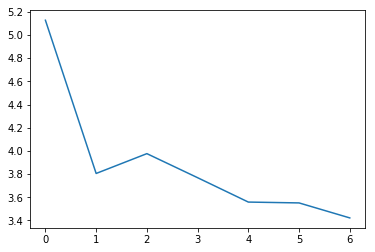

In [15]:
hidden_size = 32
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, 750, print_every=50)

In [26]:
evaluateRandomly(encoder1, decoder1, n=2)

> il est dote d une grande intelligence .
= he s highly intelligent .
< i m not . <EOS>

> je suis ivre .
= i m drunk .
< i m not . <EOS>



### AttentionDecoder

0m 1s (- 0m 15s) (50 6%) 6.7314
0m 2s (- 0m 14s) (100 13%) 5.3491
0m 3s (- 0m 12s) (150 20%) 3.6931
0m 4s (- 0m 11s) (200 26%) 4.1543
0m 5s (- 0m 10s) (250 33%) 3.8842
0m 6s (- 0m 9s) (300 40%) 3.9482
0m 6s (- 0m 7s) (350 46%) 3.7698
0m 7s (- 0m 6s) (400 53%) 3.4942
0m 8s (- 0m 5s) (450 60%) 3.5673
0m 10s (- 0m 5s) (500 66%) 3.3736
0m 11s (- 0m 4s) (550 73%) 3.4187
0m 12s (- 0m 3s) (600 80%) 3.4200
0m 13s (- 0m 2s) (650 86%) 3.5112
0m 14s (- 0m 1s) (700 93%) 3.2968
0m 15s (- 0m 0s) (750 100%) 3.2706
loss length:  7


<Figure size 432x288 with 0 Axes>

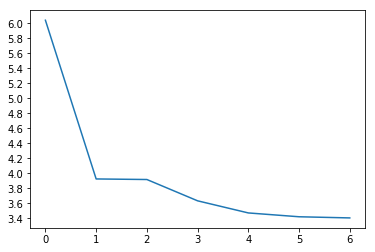

In [36]:
hidden_size = 32
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
trainIters(encoder2, attn_decoder2, 750, print_every=50)

In [39]:
evaluateRandomly(encoder2, attn_decoder2, n=2)

> tu es une de ces dragueuse !
= you re such a flirt .
< you re . <EOS>

> tu es tres intelligente .
= you re very smart .
< you re . <EOS>



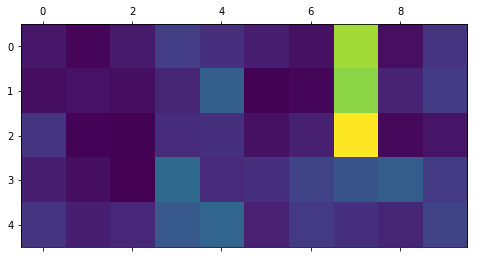

In [41]:
output_words, attentions = evaluate(encoder2, attn_decoder2, "je suis trop froid .")
plt.matshow(attentions.numpy())

In [43]:
attentions.size()

torch.Size([5, 10])

## Show

input = elle a cinq ans de moins que moi .
output = you re . <EOS>
input = elle est trop petit .
output = you re . <EOS>
input = je ne crains pas de mourir .
output = you re not . <EOS>
input = c est un jeune directeur plein de talent .
output = you re not . <EOS>


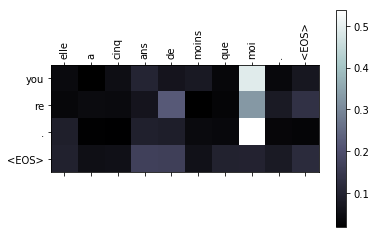

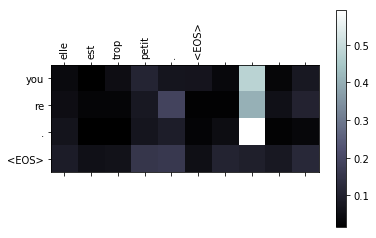

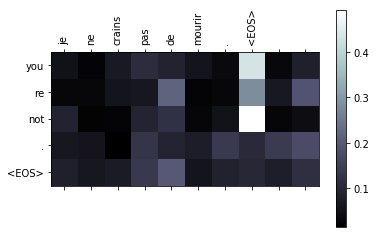

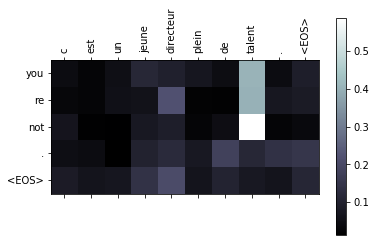

In [48]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder2, attn_decoder2, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")